## Clean data set

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

---

### Gộp dữ liệu năm 21,22,23 lại thành 1 DataFrame

In [39]:
uni_21 = pd.read_csv('../data/raw/raw_benchmark_scores_hcm_2021.csv')
uni_22 = pd.read_csv('../data/raw/raw_benchmark_scores_hcm_2022.csv')
uni_23 = pd.read_csv('../data/raw/raw_benchmark_scores_hcm_2023.csv')

In [40]:
# Thêm vào các năm tương ứng với từng dataset
uni_21['year_'] = 2021
uni_22['year_'] = 2022
uni_23['year_'] = 2023

In [41]:
# Ghép các dataframe lại với nhau
df = pd.concat([uni_21,uni_22,uni_23],ignore_index=True)

In [42]:
df = df[['year_','university_code','specialized_major','major_code','major_name','subject_group_code','note','benchmark_score']]

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6759 entries, 0 to 6758
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year_               6759 non-null   int64  
 1   university_code     6759 non-null   object 
 2   specialized_major   2227 non-null   object 
 3   major_code          6759 non-null   object 
 4   major_name          6759 non-null   object 
 5   subject_group_code  6759 non-null   object 
 6   note                5888 non-null   object 
 7   benchmark_score     6759 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 422.6+ KB


---

### Tổng quan về dữ liệu và những việc cần phải xử lý

#### 1. Tổng quan về dữ liệu

- Bảng chứa thông tin chuyển sinh các trường đại học tại TP. HCM với nhiều chuyên ngành khác nhau.
- Mỗi hàng tương ứng với các ngành đào tạo, điểm chuẩn và phương thức xét tuyển.
- Các cột chính trong bảng:
    - `year_`: Năm xét tuyển
    - `university_code`: Mã trường
    - `specialized_major`: Chuyên ngành
    - `major_name`: Ngành
    - `major_code`: Mã ngành (Mỗi trường thường sẽ có mã ngành khác nhau cho từng ngành học)
    - `subject_group_code`: Mã tổ hợp môn thi
    - `benchmark_score`: Điểm chuẩn trúng tuyển vào ngành (có nhiều thanh điểm)
    - `note`: Phương thức xét tuyển

---

#### 2. Xác định vấn đề cần giải quyết

- Thêm hệ đào tạo
- Xử lý phương thức thi `note`
    + Tốt nghiệp THPT
    + Đánh giá năng lực Đại học Quốc gia TPHCM (`subject_group_code` == DGNL và `note`)
    + Xét học bạ (dựa vào `subject_group_code` == XDHB và `note`)

- Xử lý điểm `benchmark_score`
    + Học bạ và Tốt nghiệp THPT between 1 và 30
    + Đánh giá năng lực Đại học Quốc gia TPHCM between 550 và 1200

- Xử lý tổ hợp môn thi `subject_group_code`
    + Chuẩn hoá dữ liệu, ô chứa đa trị -> chứa 1 dữ liệu duy nhất

- Drop duplicated, missing data, ...
- Thêm mã ngành theo đúng quy chuẩn của bộ

---

### Bước 1: Thêm hệ đào tạo (thêm thuộc tính `program_type`)

In [44]:
df['note'] = df['note'].str.lower()

# hiện thị các phương thức xét tuyển xuất hiện nhiều nhất
df['note'].value_counts().to_frame()

,count
note,
điểm thi tn thpt,1002
tốt nghiệp thpt,748
học bạ,561
đánh giá năng lực đại học quốc gia tphcm,328
xét học bạ,303
...,...
tốt nghiệp thpt; hệ thống nhúng và iot,1
chuyên ngành thiết kế vi mạch; đánh giá năng lực đại học quốc gia tphcm,1
chuyên ngành hệ thống nhúng và iot; đánh giá năng lực đại học quốc gia tphcm,1


In [45]:
df['major_code'].value_counts().to_frame()

,count
major_code,
7340101,172
7220201,160
7480201,141
7340301,131
7340201,116
...,...
7340101QK,1
7340101QN,1
7340101QS,1


In [46]:
criterion_lst = [
    'chất lượng cao',
    'clc',
    'ctlk',
    'chương trình tiên tiến',
    'chương trình tài năng',
    'chương trình quốc tế',
    'liên kết',
    'chương trình việt-pháp',
    'chương trình đại học chính quy quốc tế cấp song bằng',
    'chương trình đại học chính quy quốc tế song bằng',
    'ct',
    'tiên tiến',
]

# Gán 'CLC' và 'DT' từ cột 'note'
df['program_type'] = df['note'].str.contains('|'.join(criterion_lst), na=False).map({True: 'CLC', False: 'DT'})

# Cập nhật lại 'CLC' nếu có trong 'major_code', nhưng chỉ thay đổi những dòng có giá trị 'DT'
df['program_type'] = np.where(df['major_code'].str.contains(r'CLC|VP', case=False, na=False) & (df['program_type'] == 'DT'), 'CLC', df['program_type'])

---

### Bước 2: Phân tách các tổ hợp môn thi thành các dòng riêng lẻ (xử lý thuộc tính đa trị)

In [47]:
df['subject_group_code'] = df['subject_group_code'].str.replace(' ','') # bỏ đi các ký tự khoảng trắng
df['subject_group_code'] = df['subject_group_code'].str.split(',')      # chia các giá trị ra thành list, cắt theo ','

df = df.explode('subject_group_code').reset_index(drop=True)

In [48]:
df

,year_,university_code,specialized_major,major_code,major_name,subject_group_code,note,benchmark_score,program_type
0,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,điểm thi tn thpt,16.0,DT
1,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,điểm thi tn thpt,16.0,DT
2,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,điểm thi tn thpt,16.0,DT
3,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D09,điểm thi tn thpt,16.0,DT
4,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D03,điểm thi tn thpt,16.0,DT
...,...,...,...,...,...,...,...,...,...
20008,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,tốt nghiệp thpt,15.0,DT
20009,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,tốt nghiệp thpt,15.0,DT
20010,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,tốt nghiệp thpt,15.0,DT
20011,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D07,tốt nghiệp thpt,15.0,DT


---

### Bước 3: Xử lý phương thức xét tuyển (thuộc tính `note`)

In [49]:
df['subject_group_code'].value_counts().to_frame()

,count
subject_group_code,
A00,3524
A01,3355
D01,3243
XDHB,1691
DGNLHCM,1172
...,...
D95,1
DGNLSPHN,1
DGNLSPHCM,1


In [50]:
# Trong tổ hợp có nhiều cách viết đánh giá năng lực -> chuyển về thành 1 'DGNL'. Nhất quán về dữ liệu
df.loc[:,'subject_group_code']=df.loc[:,'subject_group_code'].str.replace(r'DGNLHCM|DGTD|DGNLQGHN','DGNL',regex=True)

#### Dựa vào `subject_group_code` để phân loại các phương thức xét tuyển

##### Chuẩn hoá các tổ hợp môn thi trước `subject_group_code`

In [51]:
# Khuôn mẫu cho mã tổ hợp môn thi THPT
pattern_thpt = df['subject_group_code'].str.match('^[A-Z][0-9]{2}$',na=False)

# Khuông mẫu cho phương thức xét tuyển là xét học bạ và dgnl
pattern_hocBa_dgnl = df['subject_group_code'].isin(['XDHB','DGNL'])
final_pattern = pattern_thpt | pattern_hocBa_dgnl

# Các giá trị trong `subject_group_code` không thuộc khuôn mẫu là gán là None
df.loc[~final_pattern,'subject_group_code'] = None

In [52]:
# Các bổ hợp có dạng vd: 'A00,A01, ...' -> đưa về thành phương thức THPT
df.loc[df['subject_group_code'].str.match('^[A-Z][0-9]{2}$',na=False),'note'] = 'Tốt nghiệp THPT'
df.loc[df['subject_group_code'].str.match("XDHB", na=False),'note'] = 'Xét học bạ'
df.loc[df['subject_group_code'].str.contains("DGNL", na=False),'note'] = 'Đánh giá năng lực ĐHQG-HCM'

In [53]:
# test
df['subject_group_code'].value_counts().to_frame()

,count
subject_group_code,
A00,3524
A01,3355
D01,3243
XDHB,1691
DGNL,1387
...,...
A10,1
M10,1
D95,1


In [54]:
df

,year_,university_code,specialized_major,major_code,major_name,subject_group_code,note,benchmark_score,program_type
0,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,Tốt nghiệp THPT,16.0,DT
1,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,Tốt nghiệp THPT,16.0,DT
2,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,Tốt nghiệp THPT,16.0,DT
3,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D09,Tốt nghiệp THPT,16.0,DT
4,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D03,Tốt nghiệp THPT,16.0,DT
...,...,...,...,...,...,...,...,...,...
20008,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,Tốt nghiệp THPT,15.0,DT
20009,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,Tốt nghiệp THPT,15.0,DT
20010,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,Tốt nghiệp THPT,15.0,DT
20011,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D07,Tốt nghiệp THPT,15.0,DT


Tập trung dữ liệu vào 3 phương thức xét tuyển chính

In [55]:
lst_admission_method = ['Tốt nghiệp THPT','Xét học bạ','Đánh giá năng lực ĐHQG-HCM']

correct_method = df['note'].isin(lst_admission_method)

# Chuyển các phương thức không nằm trong danh sách trên về None
df.loc[~correct_method,'note'] = None

---

### Bước 4: Xử lý điểm chuẩn

In [56]:
method_exam = df['note']
score = df['benchmark_score']

In [57]:
# Điều kiện điểm chuẩn phù hợp của Thi THPT
cond_1 = ((method_exam == 'Xét học bạ') | (method_exam == 'Tốt nghiệp THPT')) & ((score > 0.0) & (score < 30.0))

# Điều kiện điểm chuẩn phù hợp của thi DGNLHCM
cond_2 = ((method_exam == 'Đánh giá năng lực ĐHQG-HCM') & ((score >= 550.0) & (score < 1200.0)))

# Điều kiện điểm chuẩn không hợp lệ của phương thức khác, đang ở thang điểm 10
cond_3 =(( method_exam == 'Tốt nghiệp THPT') | (method_exam == 'Xét học bạ')) & (score < 10.0)

# Điều kiện điểm chuẩn của phương thức đánh giá năng lực không hợp lệ
cond_4 = ((method_exam == "Đánh giá năng lực ĐHQG-HCM") & (score < 30.0))

# Kết hợp 2 điều kiện cho 2 phương thức khác nhau
valid_cond = cond_1 | cond_2

In [58]:
df

,year_,university_code,specialized_major,major_code,major_name,subject_group_code,note,benchmark_score,program_type
0,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,Tốt nghiệp THPT,16.0,DT
1,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,Tốt nghiệp THPT,16.0,DT
2,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,Tốt nghiệp THPT,16.0,DT
3,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D09,Tốt nghiệp THPT,16.0,DT
4,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D03,Tốt nghiệp THPT,16.0,DT
...,...,...,...,...,...,...,...,...,...
20008,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,Tốt nghiệp THPT,15.0,DT
20009,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,Tốt nghiệp THPT,15.0,DT
20010,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,Tốt nghiệp THPT,15.0,DT
20011,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D07,Tốt nghiệp THPT,15.0,DT


In [59]:
# chuyển thang điểm 30 về 1200
df.loc[cond_4,'benchmark_score'] = df.loc[cond_4,'benchmark_score'] * 40.0

# chuyển thang điểm 10 về thang điểm 30
df.loc[cond_3, 'benchmark_score'] = df.loc[cond_3, 'benchmark_score'] * 3.0

# Gán None cho các dữ liệu không đạt
df.loc[~valid_cond,'benchmark_score'] = None

In [60]:
df

,year_,university_code,specialized_major,major_code,major_name,subject_group_code,note,benchmark_score,program_type
0,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,Tốt nghiệp THPT,16.0,DT
1,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,Tốt nghiệp THPT,16.0,DT
2,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,Tốt nghiệp THPT,16.0,DT
3,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D09,Tốt nghiệp THPT,16.0,DT
4,2021,HSU,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D03,Tốt nghiệp THPT,16.0,DT
...,...,...,...,...,...,...,...,...,...
20008,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A00,Tốt nghiệp THPT,15.0,DT
20009,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,A01,Tốt nghiệp THPT,15.0,DT
20010,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D01,Tốt nghiệp THPT,15.0,DT
20011,2023,UMT,NaN,7510605,Logistics và Quản lý chuỗi cung ứng,D07,Tốt nghiệp THPT,15.0,DT


---

### Bước 5: Các bước làm sạch dữ liệu khác

- dropna, fillna  
- drop_duplicated
- rename_columns

<Axes: >

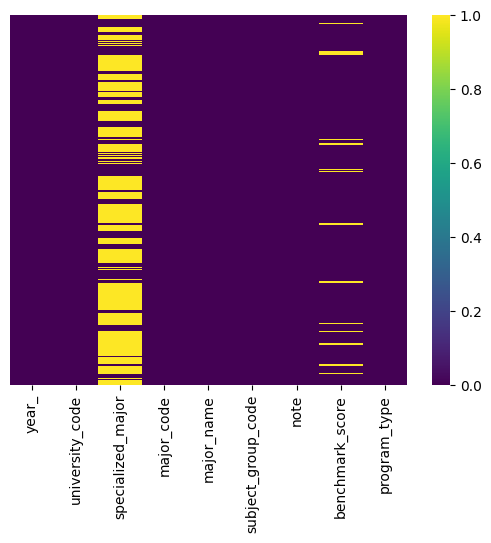

In [61]:
import seaborn as sns
%matplotlib inline
sns.heatmap(df.isna(), 
            yticklabels=False, 
            cbar=True, 
            cmap='viridis')

In [62]:
print(f"Số dòng có tổ hợp môn thi là None: {len(df[df['note'].isna()])} dòng")

Số dòng có tổ hợp môn thi là None: 28 dòng


Xoá duplicated và missing data

In [63]:
# Chuyên ngành thiếu quá nhiều dữ liệu
print(f"Phần trăm dữ liệu bị thiếu của cột `specialized_major`: {round(df['specialized_major'].isnull().sum() / df.shape[0] * 100,3)}% ")
df.drop(columns=['specialized_major'], inplace=True)

# Xoá các dòng trùng lập với key là các thuộc tính khác 'subject_group_code'
df = (
    df.groupby(['year_', 'university_code', 'major_code', 'major_name', 'note', 'benchmark_score', 'program_type'])
      .apply(lambda x: x.sample(1, random_state=42))
      .reset_index(drop=True)
)

print("Đã xóa các dòng trùng lập")

# Xoá dữ liệu None
df.dropna(inplace=True)
print("Đã xóa dữ liệu None")

# reset lại index
df.reset_index(drop=True, inplace=True) 

Phần trăm dữ liệu bị thiếu của cột `specialized_major`: 68.031% 
Đã xóa các dòng trùng lập
Đã xóa dữ liệu None


C:\Users\WELCOM AN\AppData\Local\Temp\ipykernel_340\341179522.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=42))


In [64]:
df

,year_,university_code,major_code,major_name,subject_group_code,note,benchmark_score,program_type
0,2021,FTU2,NTS01,Kinh tế,D01,Tốt nghiệp THPT,28.55,DT
1,2021,FTU2,NTS02,"Kế toán , Tài chính - Ngân hàng",D01,Tốt nghiệp THPT,28.40,DT
2,2021,GDU,7220201,Ngôn ngữ Anh,A01,Tốt nghiệp THPT,15.50,DT
3,2021,GDU,7220201,Ngôn ngữ Anh,D96,Tốt nghiệp THPT,16.50,DT
4,2021,GDU,7220201,Ngôn ngữ Anh,XDHB,Xét học bạ,16.50,DT
...,...,...,...,...,...,...,...,...
7442,2023,VNUHCM-USSH,7810103,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,27.40,DT
7443,2023,VNUHCM-USSH,7810103,Quản trị dịch vụ du lịch và lữ hành,DGNL,Đánh giá năng lực ĐHQG-HCM,790.00,DT
7444,2023,VNUHCM-USSH,7810103_CLC,Quản trị dịch vụ du lịch và lữ hành,D01,Tốt nghiệp THPT,24.50,CLC
7445,2023,VNUHCM-USSH,7810103_CLC,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,25.50,CLC


In [75]:
import seaborn as sns
%matplotlib inline
sns.heatmap(df.isna(), 
            yticklabels=True, 
            cbar=True, 
            cmap='viridis')

KeyboardInterrupt: 

: 

: 

In [66]:
df

,year_,university_code,major_code,major_name,subject_group_code,note,benchmark_score,program_type
0,2021,FTU2,NTS01,Kinh tế,D01,Tốt nghiệp THPT,28.55,DT
1,2021,FTU2,NTS02,"Kế toán , Tài chính - Ngân hàng",D01,Tốt nghiệp THPT,28.40,DT
2,2021,GDU,7220201,Ngôn ngữ Anh,A01,Tốt nghiệp THPT,15.50,DT
3,2021,GDU,7220201,Ngôn ngữ Anh,D96,Tốt nghiệp THPT,16.50,DT
4,2021,GDU,7220201,Ngôn ngữ Anh,XDHB,Xét học bạ,16.50,DT
...,...,...,...,...,...,...,...,...
7442,2023,VNUHCM-USSH,7810103,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,27.40,DT
7443,2023,VNUHCM-USSH,7810103,Quản trị dịch vụ du lịch và lữ hành,DGNL,Đánh giá năng lực ĐHQG-HCM,790.00,DT
7444,2023,VNUHCM-USSH,7810103_CLC,Quản trị dịch vụ du lịch và lữ hành,D01,Tốt nghiệp THPT,24.50,CLC
7445,2023,VNUHCM-USSH,7810103_CLC,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,25.50,CLC


In [67]:
print(f"Số dòng có tổ hợp môn thi là None: {len(df[df['note'].isna()])} dòng")

Số dòng có tổ hợp môn thi là None: 0 dòng


Chuẩn hóa các cột `major_name` và `university_code`

In [68]:
# Loại bỏ khoảng trắng thừa và chuẩn hóa chữ thường
df['major_name'] = df['major_name'].str.replace(r'\s+,', ',', regex=True).str.strip()
df['university_code'] = df['university_code'].str.strip().str.upper()

Thêm cột thang điểm để rõ ràng hơn `score_scale`

In [69]:
score_scale = {
    'Tốt nghiệp THPT': 30,
    'Xét học bạ': 30,
    'Đánh giá năng lực ĐHQG-HCM': 1200
}

# Thêm cột điểm chuẩn tương ứng với từng phương thức
df['score_scale'] = df['note'].map(score_scale)

rename:   
    `note` -> `admission_method`,   
    `year_` -> `year`,   
    `major_code` -> `uni_major_code`

In [70]:
df.rename(columns={'note':'admission_method',\
                   'year_':'year',\
                    'major_code':'uni_major_code'}, inplace=True)
df

,year,university_code,uni_major_code,major_name,subject_group_code,admission_method,benchmark_score,program_type,score_scale
0,2021,FTU2,NTS01,Kinh tế,D01,Tốt nghiệp THPT,28.55,DT,30
1,2021,FTU2,NTS02,"Kế toán, Tài chính - Ngân hàng",D01,Tốt nghiệp THPT,28.40,DT,30
2,2021,GDU,7220201,Ngôn ngữ Anh,A01,Tốt nghiệp THPT,15.50,DT,30
3,2021,GDU,7220201,Ngôn ngữ Anh,D96,Tốt nghiệp THPT,16.50,DT,30
4,2021,GDU,7220201,Ngôn ngữ Anh,XDHB,Xét học bạ,16.50,DT,30
...,...,...,...,...,...,...,...,...,...
7442,2023,VNUHCM-USSH,7810103,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,27.40,DT,30
7443,2023,VNUHCM-USSH,7810103,Quản trị dịch vụ du lịch và lữ hành,DGNL,Đánh giá năng lực ĐHQG-HCM,790.00,DT,1200
7444,2023,VNUHCM-USSH,7810103_CLC,Quản trị dịch vụ du lịch và lữ hành,D01,Tốt nghiệp THPT,24.50,CLC,30
7445,2023,VNUHCM-USSH,7810103_CLC,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,25.50,CLC,30


---

### Bước 6: Thêm cột `major_code` theo bộ đã đề ra

In [71]:
majors = pd.read_csv('../data/processed/majors.csv')

# join lại theo tên ngành
df = pd.merge(df,majors,on='major_name',how='inner')

In [72]:
df = df[['year','university_code','program_type','uni_major_code','major_code','major_name','subject_group_code','admission_method','score_scale','benchmark_score']]
df.sort_values(by=['year','university_code','program_type','major_code'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [73]:
df

,year,university_code,program_type,uni_major_code,major_code,major_name,subject_group_code,admission_method,score_scale,benchmark_score
0,2021,FTU2,DT,NTS01,7310101,Kinh tế,D01,Tốt nghiệp THPT,30,28.55
1,2021,GDU,DT,7380101,73801,Luật,A01,Tốt nghiệp THPT,30,15.00
2,2021,GDU,DT,7380101,73801,Luật,XDHB,Xét học bạ,30,16.50
3,2021,GDU,DT,7480201,74802,Công nghệ thông tin,A01,Tốt nghiệp THPT,30,16.00
4,2021,GDU,DT,7480201,74802,Công nghệ thông tin,A01,Tốt nghiệp THPT,30,16.50
...,...,...,...,...,...,...,...,...,...,...
7707,2023,VNUHCM-USSH,DT,7760101,7760101,Công tác xã hội,C00,Tốt nghiệp THPT,30,24.70
7708,2023,VNUHCM-USSH,DT,7760101,7760101,Công tác xã hội,DGNL,Đánh giá năng lực ĐHQG-HCM,1200,670.00
7709,2023,VNUHCM-USSH,DT,7810103,7810103,Quản trị dịch vụ du lịch và lữ hành,D01,Tốt nghiệp THPT,30,25.80
7710,2023,VNUHCM-USSH,DT,7810103,7810103,Quản trị dịch vụ du lịch và lữ hành,C00,Tốt nghiệp THPT,30,27.40


xuất ra file csv để tiếp tục trực quan và nghiên cứu ML

In [74]:
# df.to_csv('benchmark_scores_2021_2023_cleaned.csv', index=False)